In [1]:
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import numpy as np
import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yijieding/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(
    "../data/cases_f_cleaned.csv",
    encoding="utf-8",
    encoding_errors="ignore",
    engine="c",
    on_bad_lines="warn",
)

In [3]:
df = df.dropna(subset=['description','u_organization'],how='any')

In [4]:
df['u_organization'].value_counts()

IT Services                       369688
Budget & Finance Services         252523
Student Support                   120490
Resource Management & Planning     59718
UCPath                             37759
Research                           36028
Academic Affairs                   16360
Human Resources                    14858
Advancement                         6571
Name: u_organization, dtype: int64

In [66]:
df_top4 = df[df['u_organization'].apply(lambda s: s in ['IT Services', 'Budget & Finance Services', 'Student Support', 'Resource Management & Planning'])]
df_for_training = df_top4.sample(4000)

In [67]:
df_for_training['count'] = df_for_training['description'].apply(lambda x: len(x.split()))

<Figure size 800x800 with 0 Axes>

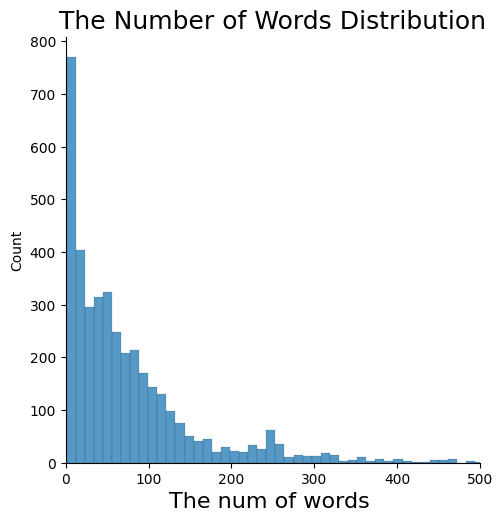

In [68]:
plt.figure(figsize= (8, 8))

sns.displot(df_for_training['count'])

plt.xlim(0, 500)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [69]:
category_count = df_for_training['u_organization'].value_counts()

categories = category_count.index

category_num = len(categories)

category_num, category_count, categories

(4,
 IT Services                       1866
 Budget & Finance Services         1258
 Student Support                    558
 Resource Management & Planning     318
 Name: u_organization, dtype: int64,
 Index(['IT Services', 'Budget & Finance Services', 'Student Support',
        'Resource Management & Planning'],
       dtype='object'))

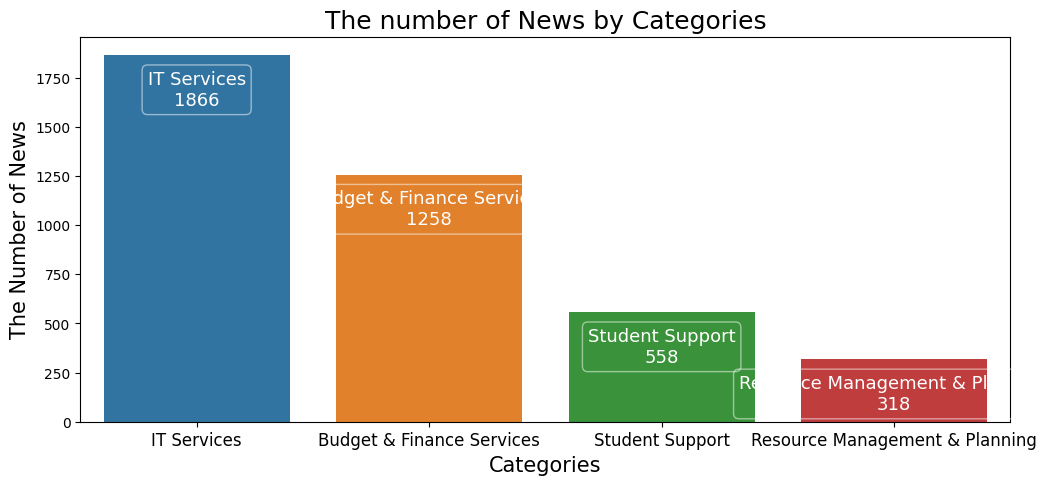

In [70]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [71]:
df_for_training['encoded_text'] = df_for_training['u_organization'].astype('category').cat.codes
df_for_training

,Unnamed: 0,short_description,description,service_offering,business_service,resolved_at,u_case_type,u_organization,count,encoded_text
178445,191985,password reset,password reset,Password reset,Instructional Account Management,2022-08-23 07:47:49,Request,IT Services,2,1
48808,53705,Scholarship check,received from: emmaetaylor23@gmail.com\n\nHell...,Financial Aid Inquiry,Financial Aid Disbursements,2022-12-21 18:27:57,Request,Student Support,81,3
813890,893158,ATTN MESSAGE COLLABORATION TEAM - Create AD Ac...,"Good afternoon Message Collaboration Team,\n\n...",Exchange Online,Email Services,2021-01-25 15:33:24,Request,IT Services,101,1
894334,979508,Compromised account: dharms,Your UCSD account has been compromised. Detail...,Password Management,Access & Identity Management,2020-10-22 10:29:44,Incident,IT Services,200,1
612167,676073,Cash Deposit Request,Cash Deposit Request - Jessica Sun,Departmental Deposits,Cashier Services,2021-09-09 11:05:58,Request,Budget & Finance Services,6,0
...,...,...,...,...,...,...,...,...,...,...
302996,330402,Academic Software License Request for: Matthew...,See variables tab for additional information.,Enterprise Software Licensing Support,End-Point Support,2022-04-26 09:07:46,Request,IT Services,6,1
34178,38257,IRR payment From UCI To UCSD for Exp As of 11/...,received from: yingy28@uci.edu\n\nGood afterno...,"AR Billing Other (Disputes, Collections, etc)",Oracle Accounts Receivable,2023-01-12 12:11:15,Request,Budget & Finance Services,76,0
585875,645288,AD PW reset for Retiree\r\n\r\n[Talkdesk] Voic...,received from: no-reply@talkdesk.com\n\nTalkde...,Active Directory - ITS,Access & Identity Management,2021-09-23 15:55:06,Request,IT Services,110,1
657391,726193,Summer Tuition and Financial Aid,"received from: c5parra@ucsd.edu\n\nHello,\n\nM...",Financial Aid Inquiry,Financial Aid Disbursements,2021-07-20 08:20:40,Request,Student Support,175,3


Budget & Finance Services - 0, IT Services - 1, Resource Management & Planning - 2, Student Support - 3 

In [72]:
data_texts = df_for_training['description'].to_list()

data_labels = df_for_training['encoded_text'].to_list()

In [73]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )

train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.1, random_state = 0 )

In [74]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', num_labels=category_num)

train_encodings = tokenizer(train_texts, truncation = True, padding = True  ) # padding to the longest sequence

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [75]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [76]:
train_dataset.element_spec

({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [77]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=category_num)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_359', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [78]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-4,               
    logging_dir='./logs',            
    eval_steps=100                   
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = category_num)


trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_379', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [79]:
trainer.train()

2023-03-06 17:43:12.159834: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 2880
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:126"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 512
        }
      }
      shape {
        dim {
          size: 512
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {


In [80]:
trainer.evaluate()

2023-03-06 18:00:58.816821: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 800
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:127"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 512
        }
      }
      shape {
        dim {
          size: 512
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
 

{'eval_loss': 0.3195043343764085}

In [88]:
save_directory = "saved_models/" 

trainer_model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('saved_models/tokenizer_config.json',
 'saved_models/special_tokens_map.json',
 'saved_models/vocab.txt',
 'saved_models/added_tokens.json')

In [89]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at saved_models/ were not used when initializing TFDistilBertForSequenceClassification: ['dropout_379']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_models/ and are newly initialized: ['dropout_419']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test model accuracy

In [90]:
test_result = np.array([],dtype=int)
for i in range(len(test_labels)):
    test_text = test_texts[i]

    predict_input = tokenizer_fine_tuned.encode(
        test_text,
        truncation = True,
        padding = True,
        return_tensors = 'tf'    
    )

    output = model_fine_tuned(predict_input)[0]

    prediction_value = tf.argmax(output, axis = 1).numpy()[0]

    test_result = np.append(test_result, prediction_value)


In [91]:
test_labels = np.array(test_labels)

In [92]:
test_result

array([1, 0, 3, 3, 1, 0, 0, 1, 1, 3, 0, 3, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 3, 2, 3, 1, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1,
       0, 0, 0, 2, 1, 1, 2, 2, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 3, 0, 0,
       3, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 3, 1,
       2, 1, 0, 1, 0, 1, 1, 1, 3, 1, 0, 1, 1, 0, 3, 2, 2, 0, 0, 3, 0, 1,
       1, 1, 0, 3, 1, 1, 3, 0, 0, 1, 1, 1, 3, 0, 1, 1, 0, 0, 3, 1, 1, 2,
       1, 1, 3, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 3, 2, 3, 0, 3, 1,
       3, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1,
       3, 3, 0, 0, 3, 3, 1, 1, 1, 0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 1, 1, 1,
       1, 2, 0, 3, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       3, 1, 0, 1, 2, 1, 3, 0, 1, 1, 0, 3, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1,
       2, 1, 1, 0, 3, 0, 3, 2, 0, 1, 1, 1, 1, 3, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 3, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0,

In [93]:
test_labels

array([1, 2, 3, 3, 1, 3, 0, 1, 1, 0, 0, 3, 0, 3, 0, 1, 2, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 3, 2, 3, 0, 0, 0, 3, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 3, 1, 3, 1, 1, 3, 0, 0, 1, 3, 1,
       0, 0, 0, 2, 1, 1, 2, 2, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 3, 1,
       2, 1, 0, 1, 0, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 2, 2, 2, 0, 3, 0, 1,
       1, 1, 0, 3, 1, 1, 3, 0, 0, 1, 3, 1, 3, 0, 1, 1, 0, 0, 3, 1, 1, 2,
       0, 1, 3, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 3, 3, 3, 1, 3, 1,
       3, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 3, 1, 1,
       3, 1, 0, 0, 3, 3, 1, 1, 1, 0, 2, 1, 1, 0, 3, 1, 0, 2, 0, 1, 1, 1,
       1, 2, 0, 3, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       3, 1, 0, 1, 2, 1, 3, 0, 1, 1, 2, 3, 1, 0, 0, 1, 0, 0, 2, 1, 0, 1,
       2, 1, 1, 2, 2, 0, 3, 2, 0, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 3, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0,

In [94]:
np.mean(test_result == test_labels)

0.890625